In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import pandas as pd
from pandas import concat
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, Normalizer, normalize
import matplotlib.pyplot as plt
from pandas import DataFrame


from numpy import concatenate
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
from keras.layers import Dense, Dropout, LSTM, BatchNormalization, TimeDistributed
from keras.layers import Conv3D, Conv2D, Conv1D, GlobalMaxPool1D, AveragePooling1D, MaxPooling1D

In [3]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib



matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [4]:
from keras.layers.convolutional import Conv2D
from keras.layers import Dense
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten

In [5]:
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adam, Adamax

In [6]:
dataset = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/dataset.csv")

In [7]:
dataset.head()

,date,new_cases,reproduction_rate,icu_patients,hosp_patients,new_tests,positive_rate,people_vaccinated,people_fully_vaccinated,new_vaccinations,Lockdown,Variant,Vaccine,GDP_PER_CAPITA,Population,Mortality_Rate
0,2020-05-01,4730.0,0.94,2178.0,14723.0,74142.0,0.088,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000010
1,2020-05-02,3230.0,0.91,2068.0,14380.0,63559.0,0.079,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000009
2,2020-05-03,2977.0,0.87,2009.0,14188.0,68203.0,0.071,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000004
3,2020-05-04,3383.0,0.82,1936.0,14097.0,72630.0,0.061,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000004
4,2020-05-05,3689.0,0.81,1874.0,13723.0,66919.0,0.057,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000011


In [8]:
dataset.set_index("date", inplace = True)

In [9]:
dataset.head()

,new_cases,reproduction_rate,icu_patients,hosp_patients,new_tests,positive_rate,people_vaccinated,people_fully_vaccinated,new_vaccinations,Lockdown,Variant,Vaccine,GDP_PER_CAPITA,Population,Mortality_Rate
date,,,,,,,,,,,,,,,
2020-05-01,4730.0,0.94,2178.0,14723.0,74142.0,0.088,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000010
2020-05-02,3230.0,0.91,2068.0,14380.0,63559.0,0.079,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000009
2020-05-03,2977.0,0.87,2009.0,14188.0,68203.0,0.071,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000004
2020-05-04,3383.0,0.82,1936.0,14097.0,72630.0,0.061,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000004
2020-05-05,3689.0,0.81,1874.0,13723.0,66919.0,0.057,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000011


In [10]:
features = ["Mortality_Rate", "new_tests", "positive_rate", "reproduction_rate", "hosp_patients"]

In [11]:
values = dataset.values

In [12]:
values[0]

array([4.73000000e+03, 9.40000000e-01, 2.17800000e+03, 1.47230000e+04,
       7.41420000e+04, 8.80000000e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.97532440e+04, 6.78860040e+07, 1.03114038e-05])

In [13]:
values = values.astype("float32")

In [14]:
scaler = StandardScaler()
scaled = scaler.fit_transform(values)

In [15]:
#the source of code --> https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	agg = concat(cols, axis=1)
	agg.columns = names
	if dropnan:
		agg.dropna(inplace = True)
	return agg


reframed = series_to_supervised(scaled, 1, 1)

In [16]:
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var13(t)  var14(t)  var15(t)
1  -0.487565  -0.398592   1.190605  ...       0.0       0.0  1.033884
2  -0.598024  -0.517112   1.084787  ...       0.0       0.0  0.058008
3  -0.616654  -0.675138   1.028030  ...       0.0       0.0  0.116795
4  -0.586757  -0.872671   0.957806  ...       0.0       0.0  1.445398
5  -0.564223  -0.912178   0.898163  ...       0.0       0.0  1.216126

[5 rows x 30 columns]


In [17]:
features = ["var2(t-1)", "var3(t-1)", "var4(t-1)", "var5(t-1)", "var1(t)"]

In [18]:
reframed = reframed[features]

In [19]:
reframed.head()

,var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
1,-0.398592,1.190605,0.556938,-1.060867,-0.598024
2,-0.517112,1.084787,0.522907,-1.088343,-0.616654
3,-0.675138,1.028030,0.503857,-1.076286,-0.586757
4,-0.872671,0.957806,0.494829,-1.064792,-0.564223
5,-0.912178,0.898163,0.457722,-1.079619,-0.553398


In [20]:
reframed = reframed.rename(columns = {'var2(t-1)': 'new_tests', 'var3(t-1)' : 'positive_rate', 'var4(t-1)' : 'reproduction_rate', 'var5(t-1)' : 'hosp_patients', 'var1(t)' : 'Mortality_Rate'})

In [21]:
values = reframed.values

In [22]:
train = values[ : 400, : ]
test = values[200: , : ]

In [23]:
X_train, Y_train = train[ : , : -1], train[ : , -1]
X_test, Y_test = test[ : , : -1], test[ : , -1]

In [24]:
X_train = X_train.reshape((X_train.shape[0], 1 , X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1 , X_test.shape[1]))

In [25]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(400, 1, 4) (400,) (36, 1, 4) (36,)


In [26]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [27]:
model = VAR(endog = X_train)
model_fit = model.fit()

In [28]:
prediction = model_fit.forecast(model_fit.y, steps = len(Y_test))

In [29]:
prediction.shape

(36, 4)

In [30]:
dataset.head()

,new_cases,reproduction_rate,icu_patients,hosp_patients,new_tests,positive_rate,people_vaccinated,people_fully_vaccinated,new_vaccinations,Lockdown,Variant,Vaccine,GDP_PER_CAPITA,Population,Mortality_Rate
date,,,,,,,,,,,,,,,
2020-05-01,4730.0,0.94,2178.0,14723.0,74142.0,0.088,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000010
2020-05-02,3230.0,0.91,2068.0,14380.0,63559.0,0.079,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000009
2020-05-03,2977.0,0.87,2009.0,14188.0,68203.0,0.071,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000004
2020-05-04,3383.0,0.82,1936.0,14097.0,72630.0,0.061,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000004
2020-05-05,3689.0,0.81,1874.0,13723.0,66919.0,0.057,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000011


In [31]:
dataset = dataset["Mortality_Rate"]

In [32]:
dataset.head()

date
2020-05-01    0.000010
2020-05-02    0.000009
2020-05-03    0.000004
2020-05-04    0.000004
2020-05-05    0.000011
Name: Mortality_Rate, dtype: float64

In [85]:
!pip install --upgrade --no-deps statsmodels

In [109]:
from statsmodels.tsa.arima.model import ARIMA

In [110]:
dataset = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/dataset.csv")

In [111]:
dataset.head()

,date,new_cases,reproduction_rate,icu_patients,hosp_patients,new_tests,positive_rate,people_vaccinated,people_fully_vaccinated,new_vaccinations,Lockdown,Variant,Vaccine,GDP_PER_CAPITA,Population,Mortality_Rate
0,2020-05-01,4730.0,0.94,2178.0,14723.0,74142.0,0.088,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000010
1,2020-05-02,3230.0,0.91,2068.0,14380.0,63559.0,0.079,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000009
2,2020-05-03,2977.0,0.87,2009.0,14188.0,68203.0,0.071,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000004
3,2020-05-04,3383.0,0.82,1936.0,14097.0,72630.0,0.061,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000004
4,2020-05-05,3689.0,0.81,1874.0,13723.0,66919.0,0.057,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000011


In [112]:
dataset.set_index("date", inplace = True)

In [113]:
dataset.head()

,new_cases,reproduction_rate,icu_patients,hosp_patients,new_tests,positive_rate,people_vaccinated,people_fully_vaccinated,new_vaccinations,Lockdown,Variant,Vaccine,GDP_PER_CAPITA,Population,Mortality_Rate
date,,,,,,,,,,,,,,,
2020-05-01,4730.0,0.94,2178.0,14723.0,74142.0,0.088,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000010
2020-05-02,3230.0,0.91,2068.0,14380.0,63559.0,0.079,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000009
2020-05-03,2977.0,0.87,2009.0,14188.0,68203.0,0.071,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000004
2020-05-04,3383.0,0.82,1936.0,14097.0,72630.0,0.061,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000004
2020-05-05,3689.0,0.81,1874.0,13723.0,66919.0,0.057,0.0,0.0,0.0,0,0,0,39753.244,67886004.0,0.000011


In [114]:
dataset = dataset["Mortality_Rate"]

In [115]:
dataset.head()

date
2020-05-01    0.000010
2020-05-02    0.000009
2020-05-03    0.000004
2020-05-04    0.000004
2020-05-05    0.000011
Name: Mortality_Rate, dtype: float64

In [116]:
from statsmodels.tsa.arima.model import ARIMA

In [117]:
values = dataset.values

In [118]:
values

array([1.03114038e-05, 8.61738747e-06, 3.72683595e-06, 4.02144748e-06,
       1.06796682e-05, 9.53068323e-06, 6.74660420e-06, 8.54373458e-06,
       4.05090864e-06, 3.19653518e-06, 2.76934845e-06, 9.05930477e-06,
       6.59929844e-06, 5.19989363e-06, 5.17043248e-06, 6.05426709e-06,
       9.86948650e-07, 2.15066422e-06, 7.38001901e-06, 4.84635979e-06,
       4.02144748e-06, 4.28659787e-06, 3.24072691e-06, 5.58288863e-06,
       1.53197999e-06, 1.92970557e-06, 6.21630344e-06, 5.05258786e-06,
       4.03617806e-06, 2.26850884e-06, 8.83834612e-07, 1.26682961e-06,
       3.68264422e-06, 3.74156652e-06, 1.91497499e-06, 3.80048883e-06,
       2.10647249e-06, 7.95451151e-07, 6.92337113e-07, 2.90192364e-06,
       2.41581461e-06, 1.11952384e-06, 1.92970557e-06, 1.57617172e-06,
       3.97725575e-07, 4.27186729e-07, 1.76766922e-06, 1.62036346e-06,
       9.86948650e-07, 1.23736846e-06, 1.04587096e-06, 4.56647883e-07,
       1.91497499e-07, 1.38467423e-06, 1.28156019e-06, 1.45832711e-06,
      

In [119]:
train = values[ : 350]

In [120]:
test = values[250 : ]

In [121]:
model = ARIMA(values, order = (5,1,0))

In [122]:
model_fit = model.fit()

In [123]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  437
Model:                 ARIMA(5, 1, 0)   Log Likelihood                4682.613
Date:                Wed, 22 Sep 2021   AIC                          -9353.226
Time:                        08:30:46   BIC                          -9328.761
Sample:                             0   HQIC                         -9343.571
                                - 437                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1954      0.000   -490.623      0.000      -0.196      -0.195
ar.L2         -0.6670      0.000  -1698.633      0.000      -0.668      -0.666
ar.L3         -0.3850      0.000  -2637.393      0.0

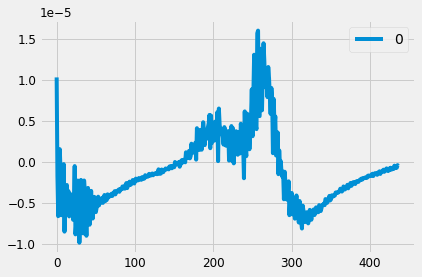

In [124]:
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()

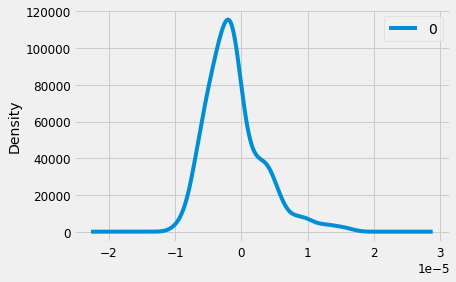

In [125]:
residuals.plot(kind = 'kde')
plt.show();

In [126]:
print(residuals.describe())

                  0
count  4.370000e+02
mean  -1.117723e-06
std    4.292620e-06
min   -9.812329e-06
25%   -3.977971e-06
50%   -1.735407e-06
75%    8.034244e-07
max    1.600906e-05


In [127]:
predictions = list()
history = [x for x in train]

In [128]:
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=0.000005, expected=0.000015
predicted=0.000015, expected=0.000017
predicted=0.000006, expected=0.000020
predicted=0.000011, expected=0.000015
predicted=0.000001, expected=0.000008
predicted=0.000004, expected=0.000008
predicted=0.000001, expected=0.000018
predicted=0.000012, expected=0.000023
predicted=0.000015, expected=0.000018
predicted=0.000009, expected=0.000019
predicted=0.000005, expected=0.000019
predicted=0.000002, expected=0.000010
predicted=0.000006, expected=0.000009
predicted=0.000011, expected=0.000024
predicted=0.000011, expected=0.000027
predicted=0.000012, expected=0.000019
predicted=0.000016, expected=0.000021
predicted=0.000012, expected=0.000020
predicted=0.000000, expected=0.000009
predicted=0.000003, expected=0.000009
predicted=0.000016, expected=0.000024
predicted=0.000018, expected=0.000025
predicted=0.000012, expected=0.000018
predicted=0.000014, expected=0.000018
predicted=0.000013, expected=0.000018
predicted=0.000005, expected=0.000009
predicted=0.

In [129]:
mse = mean_squared_error(test, predictions) 

In [130]:
mse

1.5959716619419723e-11

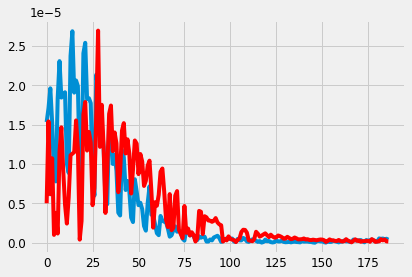

In [131]:
plt.plot(test)
plt.plot(predictions, color = 'red')
plt.show()